In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import bolift
from langchain.prompts.prompt import PromptTemplate
import copy, cloudpickle
import seaborn as sns

import os
from dotenv import load_dotenv
load_dotenv()

np.random.seed(0)

/Users/maykcaldas/miniconda3/envs/bolift/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request

urllib.request.urlretrieve(
    "https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf",
    "IBMPlexMono-Regular.ttf",
)
fe = font_manager.FontEntry(fname="IBMPlexMono-Regular.ttf", name="plexmono")
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update(
    {
        "axes.facecolor": "#f5f4e9",
        "grid.color": "#AAAAAA",
        "axes.edgecolor": "#333333",
        "figure.facecolor": "#FFFFFF",
        "axes.grid": False,
        "axes.prop_cycle": plt.cycler("color", plt.cm.Dark2.colors),
        "font.family": fe.name,
        "figure.figsize": (3.5, 3.5 / 1.2),
        "ytick.left": True,
        "xtick.bottom": True,
    }
)

import random

np.random.seed(0)
random.seed(0)

# BayesOpt Plot

In [3]:
def plot_BO(ax, data_file, title, data, axis_name, lim=None, data_file_random=None, label=False):
    d = cloudpickle.load(open(data_file, "rb"))
    if data_file_random:
      d_r = cloudpickle.load(open(data_file_random, "rb"))
    N=20
    M=5

    for i in range(M):
        if "expected_improvement" in d.keys():
          ax.plot(
            [int(s) for s in d['expected_improvement'][i,:N, -2]],
            [float(y) for y in d['expected_improvement'][i,:N, -1]], 
            color="C1", alpha=0.1
          )
        if "greedy" in d.keys():
           ax.plot(
            [int(s) for s in d['greedy'][i,:N, -2]],
            [float(y) for y in d['greedy'][i,:N, -1]], 
            color="C2", alpha=0.1
          )
        if "upper_confidence_bound" in d.keys():
          ax.plot(
            [int(s) for s in d['upper_confidence_bound'][i,:N, -2]],
            [float(y) for y in d['upper_confidence_bound'][i,:N, -1]], 
            color="C3", alpha=0.1
          )
        if "probability_of_improvement" in d.keys():
          ax.plot(
            [int(s) for s in d['probability_of_improvement'][i,:N, -2]],
            [float(y) for y in d['probability_of_improvement'][i,:N, -1]], 
            color="C4", alpha=0.1
          )
        # if "random" in d.keys():
        #   ax.plot(
        #     [int(s) for s in d['random'][i,:N, -2]],
        #     [float(y) for y in d['random'][i,:N, -1]], 
        #     color="C5", alpha=0.1
        #   )
    if "expected_improvement" in d.keys():
      label = "EI" if label else None
      ax.plot(
            d['expected_improvement'][:,:N, -2].astype('int').mean(axis=0),
            d['expected_improvement'][:,:N, -1].astype('float').mean(axis=0), 
            color="C1", label=label
          )
    if "greedy" in d.keys():
      label = "Greedy" if label else None
      ax.plot(
            d['greedy'][:,:N, -2].astype('int').mean(axis=0),
            d['greedy'][:,:N, -1].astype('float').mean(axis=0), 
            color="C2", label=label
          )
    if "upper_confidence_bound" in d.keys():
      label = "UCB" if label else None
      ax.plot(
            d['upper_confidence_bound'][:,:N, -2].astype('int').mean(axis=0),
            d['upper_confidence_bound'][:,:N, -1].astype('float').mean(axis=0), 
            color="C3", label=label
          )
    if "probability_of_improvement" in d.keys():
      label = "POI" if label else None
      ax.plot(
            d['probability_of_improvement'][:,:N, -2].astype('int').mean(axis=0),
            d['probability_of_improvement'][:,:N, -1].astype('float').mean(axis=0), 
            color="C4", label=label
          )
    # if "random" in d.keys():
    #   label = "random" if label else None
    #   ax.plot(
    #         d['random'][:,:N, -2].astype('int').mean(axis=0),
    #         d['random'][:,:N, -1].astype('float').mean(axis=0), 
    #         color="C5", label=label
    #       )
    if data_file_random:
      label = "Random" if label else None
      ax.plot(
            d_r['random_mean'][:, :N, -2].astype('int').mean(axis=0),
            d_r['random_mean'][:, :N, -1].astype('float').mean(axis=0), 
            color="gray", label=label, linestyle="dashed"
      )
    ax.axhline(y=data.max(), color="C15", linestyle="--")
    ax.text(ax.get_xlim()[1]+1, data.max(), "max", va="center", ha="left", backgroundcolor="w", fontsize=8)
    ax.axhline(y=data.quantile(0.99), color="C14", linestyle="--")
    ax.text(ax.get_xlim()[1]+1, data.quantile(0.99), "99%", va="center", ha="left", backgroundcolor="w", fontsize=8)
    ax.axhline(y=data.quantile(0.95), color="C13", linestyle="--")
    ax.text(ax.get_xlim()[1]+1, data.quantile(0.95), "95%", va="center", ha="left", backgroundcolor="w", fontsize=8)
    ax.axhline(y=data.mean(), color="C12", linestyle="--")
    ax.text(ax.get_xlim()[1]+1, data.mean(), "mean", va="center", ha="left", backgroundcolor="w", fontsize=8)
    if not data_file[:3] == "sol":
      ax.axhline(y=data.quantile(0.05), color="C11", linestyle="--")
      ax.text(ax.get_xlim()[1]+1, data.quantile(0.05)+0.3, "5%", va="center", ha="left", backgroundcolor="w", fontsize=8)
      ax.axhline(y=data.min(), color="C10", linestyle="--")
      ax.text(ax.get_xlim()[1]+1, data.min()-0.3, "min", va="center", ha="left", backgroundcolor="w", fontsize=8)
    ax.set_title(title)

    ax.set_xlabel("Number of samples")
    ax.set_ylabel(f"Measured {axis_name}")
    # ax.set_xticks([i for i in range(0,N+1,5)], [str(x * 1) for x in [i for i in range(0,N+1,5)]])
    if lim:
      ax.set_ylim(lim)
    ax.set_title(title)

### C2

In [ ]:
np.random.seed(88)

data_path = "./paper/data/C2_yield_meth_oxy_short.csv"
# data_path = "./paper/data/ada_embedd_c2_dataset.csv"
raw_data = pd.read_csv(data_path, sep=";")
# raw_data = raw_data.sample(frac=1).reset_index(drop=True)

# raw_data['completion'] = - raw_data['completion']

x_name = "prompt"
y_name = "completion"



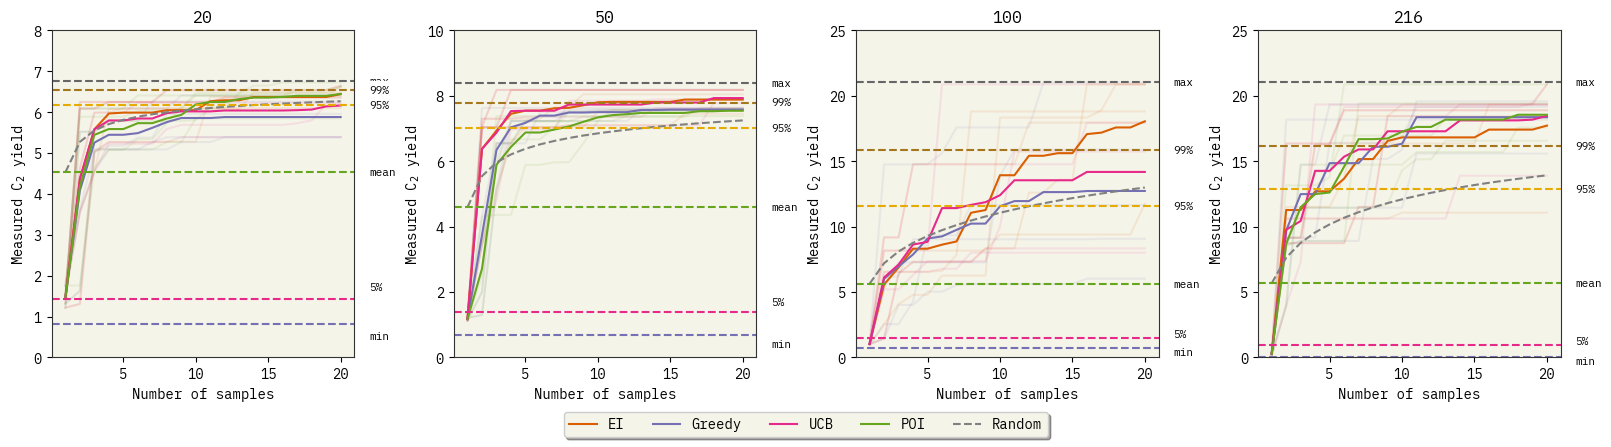

In [41]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,4), constrained_layout=True)
# for ax in axs.flat:
#     ax.set_aspect(0.6)

lim=(0,8)
raw_data = pd.read_csv("dataset/data/1180_ocm_dataset.csv", sep=";")
plot_BO(axs[0], "./out/C2_davinci_1180_1_tree.pkl","20", 
         raw_data[y_name], "C$_2$ yield", lim, label=True, data_file_random="./out/C2 - random - 1180.pkl")

lim=(0,10)
raw_data = pd.read_csv("dataset/data/2950_ocm_dataset.csv", sep=";")
plot_BO(axs[1], "./out/C2_davinci_2950_1_tree.pkl","50",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 2950.pkl")

lim=(0,25)
raw_data = pd.read_csv("dataset/data/5900_ocm_dataset.csv", sep=";")
plot_BO(axs[2], "./out/C2_davinci_5900_1_tree.pkl", "100",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 5900.pkl")

lim=(0,25)
raw_data = pd.read_csv("dataset/data/12744_ocm_dataset.csv", sep=";")
plot_BO(axs[3], "./out/C2_davinci_12744_1_tree.pkl", "216",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 12744.pkl")

fig.legend(loc='upper center', bbox_to_anchor=(0.5,0),
          fancybox=True, shadow=True, ncol=6)
plt.savefig(f"figs/BO_C2", dpi=300, bbox_inches='tight')
plt.show()

[15.62 19.15 16.14 18.23 16.79]
DaVinci is top66: 17.186
[13.11 16.14 15.18 17.94 16.14]
Gpt4 is top172: 15.702000000000002
[18.88 18.88 18.88 18.88 18.88]
GPR is top13: 18.88


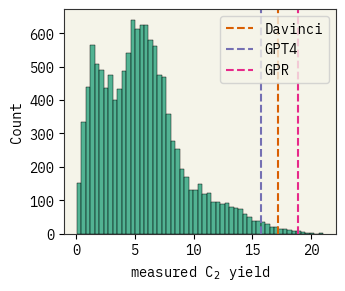

                                                  prompt  completion
737     To synthesize Mn-Na2WO4/SiO2 , SiO2 (1.0 g) w...       18.60
739     To synthesize Mn-Na2WO4/SiO2 , SiO2 (1.0 g) w...       17.25
740     To synthesize Mn-Na2WO4/SiO2 , SiO2 (1.0 g) w...       19.43
745     To synthesize Mn-Na2WO4/SiO2 , SiO2 (1.0 g) w...       21.03
746     To synthesize Mn-Na2WO4/SiO2 , SiO2 (1.0 g) w...       20.88
...                                                  ...         ...
5100    To synthesize Ti-Na2WO4/SiO2 , SiO2 (1.0 g) w...       17.56
5929    To synthesize Ni-Na2WO4/SiO2 , SiO2 (1.0 g) w...       17.66
11545   To synthesize Na2WO4/SiO2 , SiO2 (1.0 g) was ...       18.71
11546   To synthesize Na2WO4/SiO2 , SiO2 (1.0 g) was ...       17.95
11580   To synthesize Na2WO4/SiO2 , SiO2 (1.0 g) was ...       17.58

[66 rows x 2 columns]


In [9]:
d_davinci = cloudpickle.load(open("paper/out/C2_davinci_100.pkl", "rb"))
print(d_davinci['expected_improvement'][:, -1, 1].astype(float))
best_davinci = d_davinci['expected_improvement'][:, :, 1].astype(float).mean(axis=0)[-1]
print(f"DaVinci is top{np.sum(raw_data[y_name] > best_davinci)}: {best_davinci}")

d_gpt4 = cloudpickle.load(open("paper/out/C2_GPT4_100.pkl", "rb"))
print(d_gpt4['upper_confidence_bound'][:, -1, 1].astype(float))
best_gpt4 = d_gpt4['upper_confidence_bound'][:, :, 1].astype(float).mean(axis=0)[-1]
print(f"Gpt4 is top{np.sum(raw_data[y_name] > best_gpt4)}: {best_gpt4}")

d_gpr = cloudpickle.load(open("paper/out/C2_GPR_100.pkl", "rb"))
print(d_gpr['expected_improvement'][:, -1, 1].astype(float))
best_gpr = d_gpr['upper_confidence_bound'][:, :, 1].astype(float).mean(axis=0)[-1]
print(f"GPR is top{np.sum(raw_data[y_name] > best_gpr)}: {best_gpr}")

sns.histplot(raw_data[y_name])
# print(np.sum(raw_data[y_name] > best))
plt.xlabel("measured C$_2$ yield")
plt.axvline(best_davinci, color='C1', linestyle='--', label="Davinci")
plt.axvline(best_gpt4, color='C2', linestyle='--', label="GPT4")
plt.axvline(best_gpr, color='C3', linestyle='--', label="GPR")
plt.legend()
plt.savefig(f"figs/hist_C2", dpi=300, bbox_inches='tight')
plt.show()

print(raw_data[raw_data[y_name] > best_davinci])



### iupac-sol

In [437]:
np.random.seed(0)
data_path = "paper/data/esol_iupac.csv"
raw_data = pd.read_csv(data_path)
raw_data = raw_data.dropna()
raw_data = raw_data[["IUPAC", "measured log(solubility:mol/L)"]]
raw_data = raw_data.sample(frac=1).reset_index(drop=True)

# raw_data['measured log(solubility:mol/L)'] = -raw_data['measured log(solubility:mol/L)']
x_name = "IUPAC"
y_name = "measured log(solubility:mol/L)"

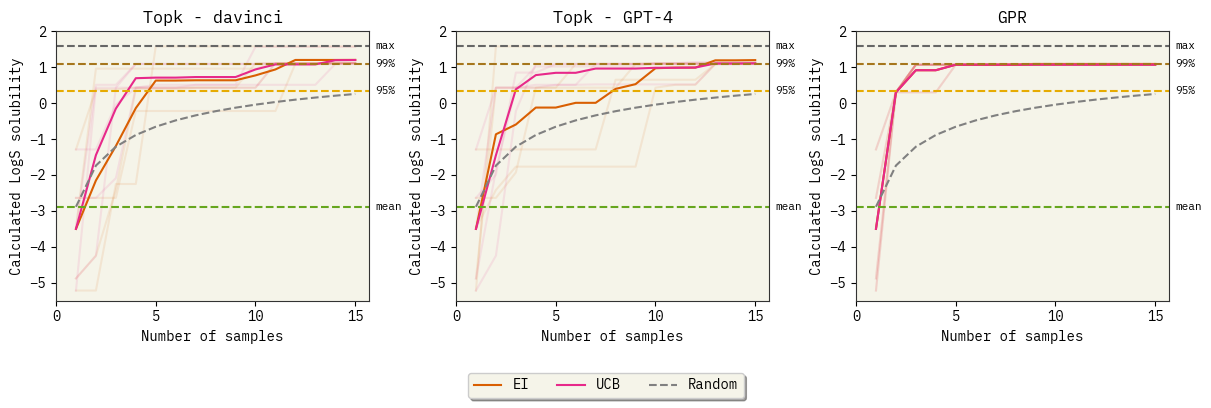

In [438]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4), constrained_layout=True)
for ax in axs.flat:
    ax.set_aspect(1.8)

lim=(-5.5,2)

plot_BO(axs[0], "paper/out/sol_davinci_100.pkl", "Topk - davinci",
         raw_data[y_name], "LogS solubility", lim, label=False, data_file_random="paper/out/sol - random.pkl")
plot_BO(axs[1], "paper/out/sol_gpt4_100.pkl", "Topk - GPT-4",
         raw_data[y_name], "LogS solubility", lim, label=False, data_file_random="paper/out/sol - random.pkl")
plot_BO(axs[2], "paper/out/sol_GPR_100.pkl", "GPR",
         raw_data[y_name], "LogS solubility", lim, label=True, data_file_random="paper/out/sol - random.pkl")

fig.legend(loc='upper center', bbox_to_anchor=(0.5,0),
          fancybox=True, shadow=True, ncol=6)
plt.savefig(f"figs/BO_sol", dpi=300, bbox_inches='tight')
plt.show()

[1.11 1.58 1.11 1.11 1.11]
DaVinci is top3: 1.2040000000000002
[1.12 1.58 1.09 1.09 1.11]
Gpt4 is top3: 1.198
[1.07 1.1  1.07 1.07 1.1 ]
GPR is top10: 1.082


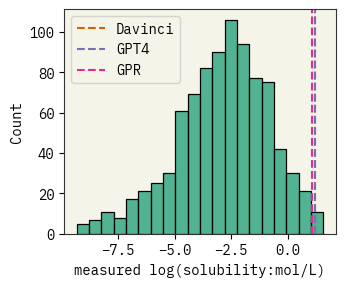

                                                 IUPAC  \
32   2-(2-dimethoxyphosphorylsulfanylethylsulfanyl)...   
36                                           acetamide   
151                                    methylhydrazine   
834                                           methanol   

     measured log(solubility:mol/L)  
32                            1.144  
36                            1.580  
151                           1.340  
834                           1.570  


In [439]:
d_davinci = cloudpickle.load(open("paper/out/sol_davinci_100.pkl", "rb"))
d_gpt4 = cloudpickle.load(open("paper/out/sol_gpt4_100.pkl", "rb"))
d_gpr = cloudpickle.load(open("paper/out/sol_GPR_100.pkl", "rb"))

print(d_davinci['expected_improvement'][:, -1, 1].astype(float))
best_davinci = d_davinci['expected_improvement'][:, :, 1].astype(float).mean(axis=0)[-1]
print(f"DaVinci is top{np.sum(raw_data[y_name] > best_davinci)}: {best_davinci}")

print(d_gpt4['expected_improvement'][:, -1, 1].astype(float))
best_gpt4 = d_gpt4['expected_improvement'][:, :, 1].astype(float).mean(axis=0)[-1]
print(f"Gpt4 is top{np.sum(raw_data[y_name] > best_gpt4)}: {best_gpt4}")

print(d_gpr['expected_improvement'][:, -1, 1].astype(float))
best_gpr = d_gpr['expected_improvement'][:, :, 1].astype(float).mean(axis=0)[-1]
print(f"GPR is top{np.sum(raw_data[y_name] > best_gpr)}: {best_gpr}")

sns.histplot(raw_data[y_name])
plt.axvline(best_davinci, color='C1', linestyle='--', label="Davinci")
plt.axvline(best_gpt4, color='C2', linestyle='--', label="GPT4")
plt.axvline(best_gpr, color='C3', linestyle='--', label="GPR")
plt.legend()
plt.savefig(f"figs/hist_sol", dpi=300, bbox_inches='tight')
plt.show()

print(raw_data[raw_data[y_name] > best_davinci-0.08])



# BayesOpt experiments

In [4]:
import uncertainty_toolbox as uct

def combine(s, l):
  '''Number of combinations of l elements with max = s'''
  return (s**l - (s-1)**(l))

def prob(s, l, n):
  '''Probability of getting a sample with max([x0,x1,...,xl]) = s where xi={0,n}'''
  return combine(s,l) * ((1/n)**l)

def expected_value_p(l, n):
  '''Expected value of max([x0,x1,...,xl]) where xi={0,n}'''
  E = [s * prob(s, l, n) for s in range(1,100+1)]
  return sum(E)

def expected_value_q(l, n, data):
  '''Expected value of max([x0,x1,...,xl]) where xi={0,n}'''
  quants = [data.quantile(i/100) for i in range(100+1)]
  # E = [(quants[s-1]) * prob(s, l, n) for s in range(1,100+1)]
  E = [((quants[s-1]+quants[s])/2) * prob(s, l, n) for s in range(1,100+1)]
  return sum(E)

from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)

@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def run_experiment(
    asktell, pool, raw_data, indexes, x_name, y_name, N=10, initial_train=1, ask_K=1, aq="random", start_index=0, calibrate=False
):
    if aq=='random_mean':
       return [ (i, expected_value_q(i, 100, raw_data[y_name])) for i in range(1,N+1) ]
    for i in indexes[:initial_train]:
        asktell.tell(raw_data[x_name].iloc[i], float(raw_data[y_name].iloc[i]))
    if calibrate:
        # y = [float(raw_data[y_name].iloc[i]) for i in indexes[:initial_train]]
        # pred = asktell.predict(y)
        # ymeans = np.array([yhi.mean() for yhi in pred])
        # ystds = np.array([yhi.std() for yhi in pred])
        # calibration_factor = uct.recalibration.optimize_recalibration_ratio(ymeans, ystds, np.array(y), criterion="miscal")
        calibration_factor = 5.0
        asktell.set_calibration_factor(calibration_factor)

    # x = [raw_data[x_name].iloc[i] for i in indexes]
    x = raw_data[x_name].tolist()

    pool.reset()
    xi = x[start_index]
    x.remove(xi)
    pool.choose(xi)
    yi = float(raw_data[raw_data[x_name] == xi][y_name].iloc[0])
    asktell.tell(xi, yi)
    point = [(xi, initial_train, yi)]
    best = point[0][-1]
    for i in range(1, N):
        if i == N - 1 and aq != "random":
            aq = "greedy"
        px, _, py = asktell.ask(pool, 
                                k=ask_K, 
                                aq_fxn=aq, 
                                _lambda=1.0, 
                                inv_filter=8, 
                                aug_random_filter=8
                                )
        for j in range(ask_K):
          xc = px[j]
          x.remove(xc)
          pool.choose(xc)
          y = float(raw_data[raw_data[x_name] == xc][y_name].iloc[0])
          asktell.tell(xc, y)
          best = max(y, best)
        point.append((xc, initial_train+i*ask_K, best))
    return point

### C2

In [5]:
# asktell = bolift.AskTellFewShotMulti(
#   x_formatter=lambda x: f"experimental procedure: {x}",
#   y_name="C2 yield",
#   y_formatter=lambda y: f"{y:.2f}",
#   model="text-curie-001",
#   selector_k=5,
#   temperature=0.05
# )

asktell = bolift.AskTellFewShotTopk(
  prefix="",
  prompt_template=PromptTemplate(
      input_variables=["x", "y", "y_name"],
      template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
  ),
  suffix="What is the {y_name} of {x}?@@@\nA:",
  x_formatter=lambda x: f"experimental procedure: {x}",
  y_name="C2 yield",
  y_formatter=lambda y: f"{y:.2f}",
  model="text-curie-001",
  # model="text-davinci-003",
  selector_k=5,
  temperature=0.7,
)

# asktell = bolift.AskTellGPR(
#   prefix="The following question should be answered with a number\n",
#   prompt_template=PromptTemplate(
#       input_variables=["x", "y", "y_name"],
#       template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
#   ),
#   suffix="What is the {y_name} of {x}?@@@\nA:",
#   x_formatter=lambda x: f"experimental procedure: {x}",
#   y_name="C2 yield",
#   y_formatter=lambda y: f"{y:.2f}",
#   model='text-ada-001',
#   pool=bolift.Pool([raw_data[x_name].iloc[i] for i in range(1000)], formatter=lambda x: f"experimental procedure: {x}"),
#   n_components=32,
#   # cache_path="GPR_ada_embed_cache.csv"
# )

# asktell = bolift.AskTellRidgeKernelRegression(
#     prefix="The following question should be answered with a number\n",
#     prompt_template=PromptTemplate(
#         input_variables=["x", "y", "y_name"],
#         template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
#     ),
#     suffix="What is the {y_name} of {x}?@@@\nA:",
#     x_formatter=lambda x: f"iupac name {x}",
#     y_name="measured log solubility in mols per litre",
#     y_formatter=lambda y: f"{y:.2f}",
#     model="text-ada-001",
#     alpha=0.5
#   )

In [6]:
np.random.seed(88)

data_path = "./dataset/data/1180_ocm_dataset.csv"

path_random = "./out/C2 - random - 1180.pkl"
# template:    db_model_dbFilter_initial_pool
path = "./out/C2_davinci_1180_1_16hh.pkl"
pool_path = "./dataset/data/1180_ocm_pool.pkl"

initial_train = 1
ask_K = 1

raw_data = pd.read_csv(data_path, sep=";")

# raw_data['completion'] = - raw_data['completion']

print(raw_data.iloc[678])

N = raw_data.shape[0]
indexes = np.random.choice(raw_data.shape[0], int(N), replace=False)
x_name = "prompt"
y_name = "completion"
print(N, len(indexes))

if os.path.exists(pool_path):
  with open(pool_path, "rb") as f:
    pool = cloudpickle.load(f)
  pool.reset()
else:
  x = [raw_data[x_name].iloc[i] for i in indexes]
  pool = bolift.Pool(list(x), formatter=lambda x: f"experimental procedure: {x}")
  cloudpickle.dump(pool, open(pool_path, "wb"))

N = 20
M = 5
starts = raw_data.sort_values(by=y_name, ascending=True).head(100).sample(M)# np.random.randint(0, len(indexes), M)
print(starts)
starts = starts.index
print(starts)


prompt        To synthesize Pd-Na2WO4/SiO2, SiO2 (1.0 g) was...
completion                                                 0.95
Name: 678, dtype: object
1180 1180
                                                 prompt  completion
978   To synthesize ZSM-5, ZSM-5 (1.0 g) was impregn...        1.22
964   To synthesize ZSM-5, ZSM-5 (1.0 g) was impregn...        1.76
1147  To synthesize WOx/SiO2, SiO2 (1.0 g) was impre...        1.32
677   To synthesize Pd-Na2WO4/SiO2, SiO2 (1.0 g) was...        1.47
825   To synthesize BN, BN (1.0 g) was impregnated w...        1.55
Index([978, 964, 1147, 677, 825], dtype='int64')


In [7]:
if os.path.exists(path):
    bayesOpts_random = cloudpickle.load(open(path_random, "rb")) #random_mean
    bayesOpts = cloudpickle.load(open(path, "rb"))
else:
    bayesOpts = {}

for aq in ["random", "expected_improvement", "greedy", 'upper_confidence_bound', 'probability_of_improvement']:
    print(aq, "start:", end=" ")
    points = []
    for i in range(M):
        print(i, end=",  ")
        point = run_experiment(
            copy.deepcopy(asktell),
            copy.deepcopy(pool),
            raw_data,
            indexes,
            x_name,
            y_name,
            N=N,
            aq=aq,
            start_index=starts[i],
            calibrate=True,
            initial_train=initial_train,
            ask_K=ask_K
        )
        points.append(point)
    points = np.array(points)
    bayesOpts[aq] = points
    print(aq, "done")
    # asktell.save_cache("GPR_ada_embed_cache.csv")
    cloudpickle.dump(bayesOpts, open(path, "wb"))
cloudpickle.dump(bayesOpts, open(path, "wb"))


random start: 0,  1,  2,  3,  4,  random done
expected_improvement start: 0,  

KeyboardInterrupt: 

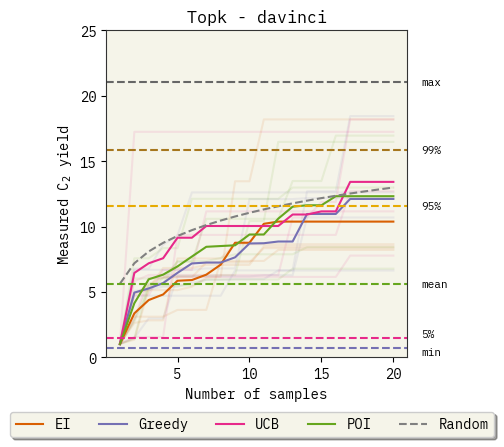

In [66]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4,4), constrained_layout=True)
# for ax in axs.flat:
#     ax.set_aspect(0.6)

lim=(0,25)

plot_BO(axs, path, "Topk - davinci", 
         raw_data[y_name], "C$_2$ yield", lim, label=True, data_file_random=path_random)

fig.legend(loc='upper center', bbox_to_anchor=(0.5,0),
          fancybox=True, shadow=True, ncol=6)
plt.savefig(f"figs/BO_C2", dpi=300, bbox_inches='tight')
plt.show()

[17.95 18.81 11.75 20.88 20.88]
DaVinci is top16: 18.054


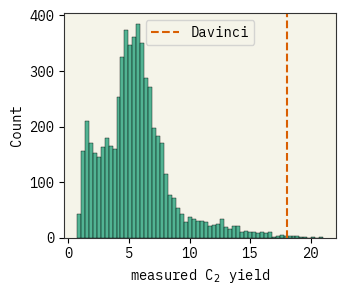

                                                 prompt  completion
389   To synthesize Mn-Na2WO4/SiO2, SiO2 (1.0 g) was...       18.60
392   To synthesize Mn-Na2WO4/SiO2, SiO2 (1.0 g) was...       19.43
397   To synthesize Mn-Na2WO4/SiO2, SiO2 (1.0 g) was...       21.03
398   To synthesize Mn-Na2WO4/SiO2, SiO2 (1.0 g) was...       20.88
399   To synthesize Mn-Na2WO4/SiO2, SiO2 (1.0 g) was...       18.90
498   To synthesize Mn-Na2WO4/SiC, SiC (1.0 g) was i...       18.45
597   To synthesize Mn-Na2WO4/SiCnf, SiCnf (1.0 g) w...       18.34
598   To synthesize Mn-Na2WO4/SiCnf, SiCnf (1.0 g) w...       19.15
1297  To synthesize Mn-Li2WO4/SiO2, SiO2 (1.0 g) was...       18.81
1299  To synthesize Mn-Li2WO4/SiO2, SiO2 (1.0 g) was...       18.22
1498  To synthesize Mn-K2WO4/SiO2, SiO2 (1.0 g) was ...       18.20
2386  To synthesize Ti-Na2WO4/SiO2, SiO2 (1.0 g) was...       18.32
2396  To synthesize Ti-Na2WO4/SiO2, SiO2 (1.0 g) was...       20.23
2397  To synthesize Ti-Na2WO4/SiO2, SiO2 (1.0 g)

In [17]:
import seaborn as sns

d_davinci = cloudpickle.load(open(path, "rb"))
print(d_davinci['expected_improvement'][:, -1, -1].astype(float))
best_davinci = d_davinci['expected_improvement'][:, :, -1].astype(float).mean(axis=0)[-1]
print(f"DaVinci is top{np.sum(raw_data[y_name] > best_davinci)}: {best_davinci}")

sns.histplot(raw_data[y_name])
# print(np.sum(raw_data[y_name] > best))
plt.xlabel("measured C$_2$ yield")
plt.axvline(best_davinci, color='C1', linestyle='--', label="Davinci")
plt.legend()
plt.savefig(f"figs/hist_C2", dpi=300, bbox_inches='tight')
plt.show()

print(raw_data[raw_data[y_name] > best_davinci])



### IUPAC-Solubility

In [22]:
np.random.seed(0)

data_path = "paper/data/esol_iupac.csv"
raw_data = pd.read_csv(data_path)
raw_data = raw_data.dropna()
raw_data = raw_data[["IUPAC", "measured log(solubility:mol/L)"]]
raw_data = raw_data.sample(frac=1).reset_index(drop=True)

# raw_data['measured log(solubility:mol/L)'] = -raw_data['measured log(solubility:mol/L)']

print(raw_data.columns)

N = raw_data.shape[0]
indexes = [i for i in range(N)]  # np.random.choice(raw_data.shape[0], int(N), replace=False)
x_name = "IUPAC"
y_name = "measured log(solubility:mol/L)"
print(len(raw_data), len(indexes))

asktell = bolift.AskTellFewShotTopk(
  prefix="",
  prompt_template=PromptTemplate(
      input_variables=["x", "y", "y_name"],
      template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
  ),
  suffix="What is the {y_name} of {x}?@@@\nA:",
  x_formatter=lambda x: f"iupac name {x}",
  y_name="measured log solubility in mols per litre",
  y_formatter=lambda y: f"{y:.2f}",
  model="text-davinci-003",
  selector_k=5,
  temperature=0.7,
)

# asktell = bolift.AskTellFewShotMulti(
#     x_formatter=lambda x: f"iupac name {x}",
#     y_name="measured log solubility in mols per litre",
#     y_formatter=lambda y: f"{y:.2f}",
#     model="text-curie-001",
#     selector_k=5,
#     temperature=0.05
# )

# asktell = bolift.AskTellGPR(
#   prefix="The following question should be answered with a number\n",
#   prompt_template=PromptTemplate(
#       input_variables=["x", "y", "y_name"],
#       template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
#   ),
#   suffix="What is the {y_name} of {x}?@@@\nA:",
#   x_formatter=lambda x: f"iupac name {x}",
#   y_name="measured log solubility in mols per litre",
#   y_formatter=lambda y: f"{y:.2f}",
#   model='text-ada-001',
#   pool=bolift.Pool(raw_data[x_name].to_list(), formatter=lambda x: f"iupac name {x}"),
#   n_components=16,
# )

Index(['IUPAC', 'measured log(solubility:mol/L)'], dtype='object')
882 882


In [37]:
x = [raw_data[x_name].iloc[i] for i in indexes]
path_random = "paper/out/sol - random.pkl"
path = "paper/out/sol_davinci_100.pkl"
pool_path = "paper/out/sol_pool.pkl"

if os.path.exists(pool_path):
  with open(pool_path, "rb") as f:
    pool = cloudpickle.load(f)
  pool.reset()
else:
  x = [raw_data[x_name].iloc[i] for i in indexes]
  pool = bolift.Pool(list(x), formatter=lambda x: f"experimental procedure: {x}")
  cloudpickle.dump(pool, open(pool_path, "wb"))

N = 15
M = 5
starts = np.random.randint(0, len(indexes), M)
# starts = [110, 374, 790, 365, 523, 119, 560, 199, 239, 694, 608, 850, 599, 405, 510, 514, 264, 266, 261, 294, 612]
# print([raw_data[y_name].iloc[i] for i in starts])

In [ ]:
if os.path.exists(path):
    bayesOpts_random = cloudpickle.load(open(path_random, "rb"))
    bayesOpts = cloudpickle.load(open(path, "rb"))
else:
    bayesOpts = {}

for aq in ["random", "expected_improvement", "greedy", 'upper_confidence_bound', 'probability_of_improvement']:
    print(aq, "start:", end=" ")
    points = []
    for i in range(M):
        print(i, end=",  ")
        point = run_experiment(
            copy.deepcopy(asktell),
            copy.deepcopy(pool),
            raw_data,
            indexes,
            x_name,
            y_name,
            N=N,
            aq=aq,
            start_index=starts[i],
            calibrate=True,
            initial_train=100
        )
        points.append(point)
    # plot mean
    points = np.array(points)
    bayesOpts[aq] = points
    print(aq, "done")
    # asktell.save_cache("GPR_ada_embed_cache.csv")
    cloudpickle.dump(bayesOpts, open(path, "wb"))

cloudpickle.dump(bayesOpts, open(path, "wb"))

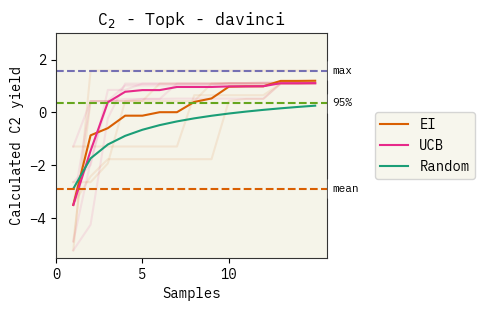

In [54]:
d = cloudpickle.load(open(path, "rb"))
d_r = cloudpickle.load(open(path_random, "rb"))
N=15
M=5

plt.figure(figsize=(3.5, 3.5 / 1.2))
for i in range(M):
    plt.plot(range(1, N + 1), [float(y) for x, y in d['expected_improvement'][i,:N]], color="C1", alpha=0.1)
    plt.plot(range(1, N + 1), [float(y) for x, y in d['greedy'][i,:N]], color="C2", alpha=0.1)
    plt.plot(range(1, N + 1), [float(y) for x, y in d['upper_confidence_bound'][i,:N]], color="C3", alpha=0.1)
    plt.plot(range(1, N + 1), [float(y) for x, y in d['probability_of_improvement'][i,:N]], color="C4", alpha=0.1)
    plt.plot(range(1, N + 1), [float(y) for x, y in d['random'][i,:N]], color="C0", alpha=0.1)
plt.plot(
    range(1, N + 1), d['expected_improvement'][:, :N, 1].astype(float).mean(axis=0), color="C1", label="EI"
)
plt.plot(
    range(1, N + 1), d['greedy'][:, :N, 1].astype(float).mean(axis=0), color="C2", label="Greedy",
)
plt.plot(
    range(1, N + 1), d['upper_confidence_bound'][:, :N, 1].astype(float).mean(axis=0), color="C3", label="UCB",
)
plt.plot(
    range(1, N + 1), d['probability_of_improvement'][:, :N, 1].astype(float).mean(axis=0), color="C4", label="POI",
)
plt.plot(
    range(1, N + 1), d_r['random_mean'][:, :N, 1].astype(float).mean(axis=0), color="C0", label="Random",
)
plt.axhline(y=raw_data[y_name].max(), color="C2", linestyle="--")
plt.text(N + 1, raw_data[y_name].max(), "max", va="center", ha="left", backgroundcolor="w", fontsize=8)
plt.axhline(y=raw_data[y_name].quantile(0.95), color="C4", linestyle="--")
plt.text(N + 1, raw_data[y_name].quantile(0.95), "95%", va="center", ha="left", backgroundcolor="w", fontsize=8)
plt.axhline(y=raw_data[y_name].mean(), color="C1", linestyle="--")
plt.text(N + 1, raw_data[y_name].mean(), "mean", va="center", ha="left", backgroundcolor="w", fontsize=8)
# plt.axhline(y=raw_data[y_name].quantile(0.05), color="C3", linestyle="--")
# plt.text(N + 1, raw_data[y_name].quantile(0.05)+0.3, "5%", va="center", ha="left", backgroundcolor="w", fontsize=8)
# plt.axhline(y=raw_data[y_name].min(), color="C0", linestyle="--")
# plt.text(N + 1, raw_data[y_name].min()-0.3, "min", va="center", ha="left", backgroundcolor="w", fontsize=8)

plt.xlabel("Samples")
plt.ylabel("Calculated C2 yield")
# reduce number of ticks
plt.xticks([i for i in range(0,N+1,5)], [str(x * 1) for x in [i for i in range(0,N+1,5)]])
plt.ylim(-5.5, 3)
# plt.yticks(np.linspace(-10, 0, 3))
plt.title("C$_2$ - Topk - davinci")
plt.legend(loc="center left", bbox_to_anchor=(1.15, 0.5))

1.198
3


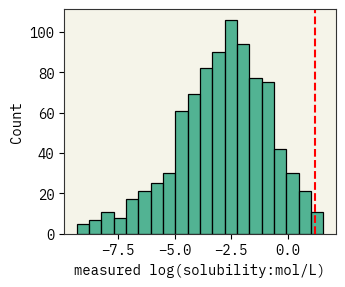

In [51]:
import seaborn as sns

d['expected_improvement'][1][-1][1]
best = d['expected_improvement'][:, :, 1].astype(float).mean(axis=0)[-1]
print(best)

sns.histplot(raw_data[y_name])
print(np.sum(raw_data[y_name] > best))
plt.axvline(best, color='red', linestyle='--')
plt.show()


### Alloy

In [ ]:
import pandas as pd
import numpy as np

np.random.seed(0)

data_path = "paper/data/yield_strength.csv"
raw_data = pd.read_csv(data_path)
# raw_data = raw_data.sample(frac=1).reset_index(drop=True)

print(raw_data.columns)

N = raw_data.shape[0]
indexes = np.random.choice(raw_data.shape[0], int(N), replace=False)
# shuffle test

print(N, len(indexes))

asktell = bolift.AskTellFewShotTopk(
    prefix="",
    prompt_template=PromptTemplate(
        input_variables=["x", "y", "y_name"],
        template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
    ),
    suffix="What is the {y_name} of {x}?@@@\nA:",
    # x_formatter=lambda x: f"alloy composition: {x}",
    y_name="yield strength",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-4",
    selector_k=5,
)


x_name = "composition"
y_name = "yield strength"


In [ ]:
N = 10
M = 5
starts = np.random.randint(0, len(indexes), M)
plt.figure(figsize=(3.5, 3.5 / 1.2))
random_points = []
for i in range(M):
    point = run_experiment(
        asktell,
        raw_data,
        indexes,
        x_name,
        y_name,
        N=N,
        aq="random",
        start_index=starts[i],
    )
    random_points.append(point)
    plt.plot(range(N + 1), [y for x, y in point], color="C0", alpha=0.1)
# plot mean
random_points = np.array(random_points)
plt.plot(
    range(N + 1),
    random_points[:, :, 1].astype(float).mean(axis=0),
    color="C0",
    label="Random",
)

greedy_points = []
for i in range(M):
    point = run_experiment(
        asktell,
        raw_data,
        indexes,
        x_name,
        y_name,
        N=N,
        aq="greedy",
        start_index=starts[i],
    )
    greedy_points.append(point)
    plt.plot(range(N + 1), [y for x, y in point], color="C2", alpha=0.1)
# plot mean
greedy_points = np.array(greedy_points)
plt.plot(
    range(N + 1),
    greedy_points[:, :, 1].astype(float).mean(axis=0),
    color="C2",
    label="Greedy",
)

ei_points = []
for i in range(M):
    point = run_experiment(
        asktell,
        raw_data,
        indexes,
        x_name,
        y_name,
        N=N,
        aq="expected_improvement",
        start_index=starts[i],
    )
    ei_points.append(point)
    plt.plot(range(N + 1), [y for x, y in point], color="C1", alpha=0.1)
# plot mean
ei_points = np.array(ei_points)
plt.plot(
    range(N + 1), ei_points[:, :, 1].astype(float).mean(axis=0), color="C1", label="EI"
)

plt.axhline(y=raw_data["yield strength"].min(), color="C0", linestyle="--", label="min")
plt.axhline(
    y=raw_data["yield strength"].mean(), color="C1", linestyle="--", label="mean"
)
plt.axhline(y=raw_data["yield strength"].max(), color="C2", linestyle="--", label="max")
# give 5% quantiles
plt.axhline(
    y=raw_data["yield strength"].quantile(0.05), color="C3", linestyle="--", label="5%"
)
plt.axhline(
    y=raw_data["yield strength"].quantile(0.95), color="C4", linestyle="--", label="95%"
)

plt.xlabel("Samples")
# reduce number of ticks
# plt.xticks([0, 5, 10])
# plt.ylim(-10, 0)
# plt.yticks(np.linspace(-10, 0, 3))
plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
plt.savefig("concept_multi.png", dpi=300)